<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S13_Time_Series_taxi_orders_in_next_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Descrition
Sweet Lift Taxi company has collected historical data on taxi orders at
airports. To attract more drivers during peak hours, we need to predict the
amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.
##Project instructions
1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample
should be 10% of the initial dataset.
4. Test the data using the test sample and provide a conclusion.

## Data description
The data is stored in the /datasets/taxi.csv file. Download the dataset.
The number of orders is in the num_orders column.

## Project evaluation
- How did you prepare the data?
- What models and hyperparameters have you considered?
- Have you managed to avoid code duplication?
- What are your findings?
- Have you kept to the project structure?
- Have you kept the code neat?


In [93]:
colab = True
if colab:
    data_path = 'https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/taxi.csv'
else:
    data_path = '/datasets/taxi.csv'

In [94]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

# 1. Data download and Resampling (1H)

In [119]:
data = pd.read_csv(data_path, index_col=[0],  parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#2. EDA Analysis and Features Engineering

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


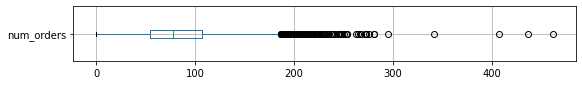

In [120]:
print(data.info())
data.boxplot(vert=False, figsize=(9,1));

As above, the data consists of hourly number of orders for the period 1/3/2018 to 31/8/2018. The majority number of orders is below 200 per hour, with few peaks above 300.

We will add `month`, `day`, `dayofweek`, `hour` as features in order to enhance the models. Note: no nead for year, since all data is in same year (2018)

In [121]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

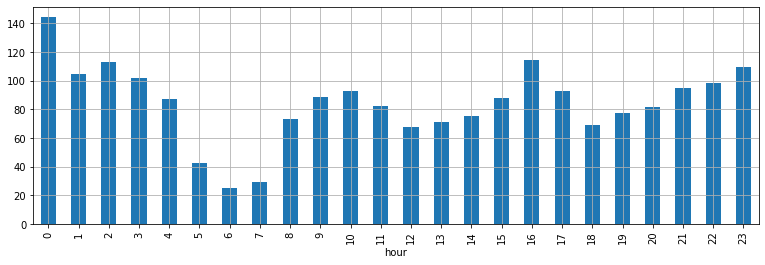

In [122]:
data.groupby('hour')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(13, 4));

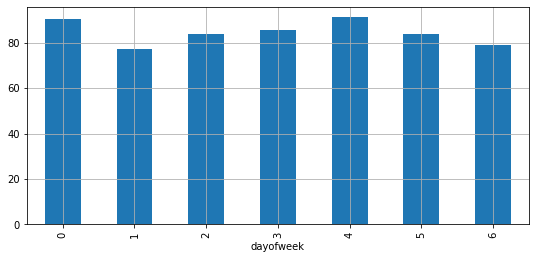

In [123]:
data.groupby('dayofweek')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(9, 4));

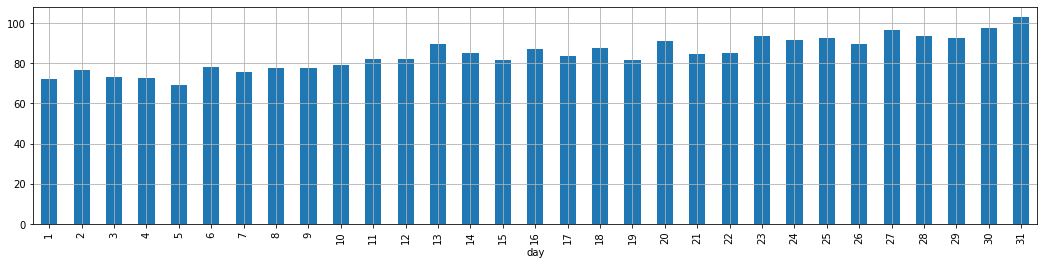

In [124]:
data.groupby('day')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(18, 4));

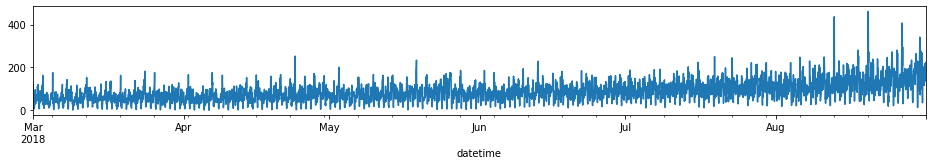

In [125]:
data['num_orders'].plot(figsize=(16, 2));

We can notice a trend of growth of during the whole period of 8 months. There are peaks above 300 in August - let's focus on them, by zooming on August:

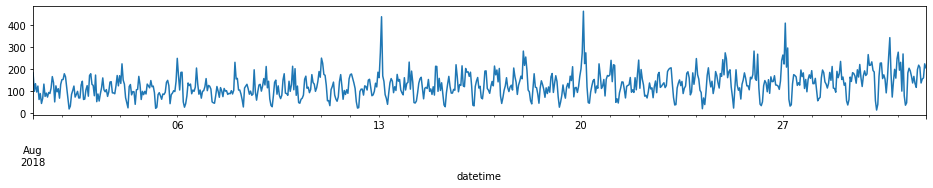

In [126]:
data['2018-08-01':'2018-08-31']['num_orders'].plot(figsize=(16, 2));

The peaks occur in the last 3 weekends (00:00 - 01:00 on the nights between Sunday and Monday.

Let's proceed by deeper looking on last week of August:

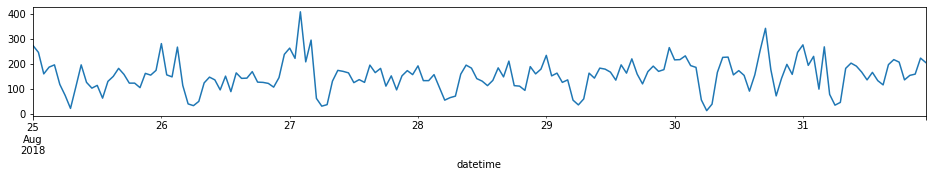

In [127]:
data['2018-08-25':'2018-08-31']['num_orders'].plot(figsize=(16, 2));

We can notice that the daily low frequency occurs in early mornings (05:00 - 07:00), with high frequencies in the evenings and top frequencies in the night ending weekends, as already mentioned.

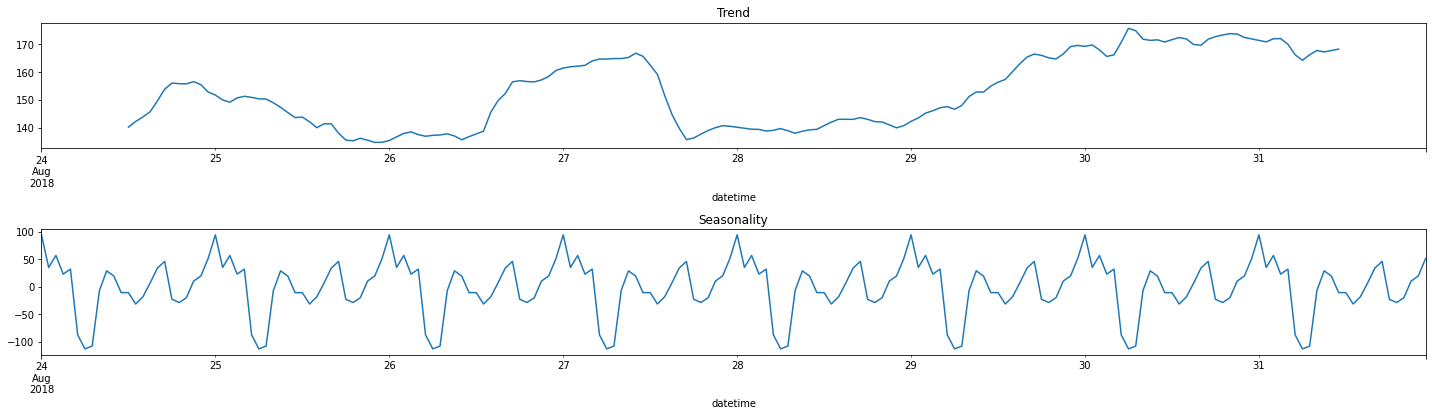

In [128]:
decomposed = seasonal_decompose(data['2018-08-24':'2018-08-31']['num_orders'])
plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),)
plt.title('Seasonality')

plt.tight_layout()

Same as stated before, is dispayed above using decomposition.

In [151]:
def prepare_sets(max_lag, rolling_mean_size):
    df = data.copy()
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
    train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

    train = train.dropna()

    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders'] 
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders'] 
    return features_train, target_train, features_valid, target_valid, features_test, target_test

In [172]:
def print_rmse():
    rmse_train = mean_squared_error(target_train, prediction_train) ** 0.5
    rmse_valid = mean_squared_error(target_valid, prediction_valid) ** 0.5
    rmse_test = mean_squared_error(target_test, prediction_test) ** 0.5
    print(f'RMSE Train: {rmse_train:,.0f}, Valid: {rmse_valid:,.0f}, Test: {rmse_test:,.0f}, diff(Train,Valid):{100*(rmse_valid - rmse_train)/rmse_train:,.1f}%')

In [176]:
def eval_model (model_type, max_lag, rolling_mean_size):
    features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag, rolling_mean_size)
    model = model_type()
    model.fit(features_train, target_train)
    print(f'{model_type.__name__},max_lag:{max_lag},'\
          f'rolling_mean_size:{rolling_mean_size},'\
          f'RMSE train: {sqrt(mean_squared_error(target_train, model.predict(features_train))):.1f},'\
          f'RMSE valid: {sqrt(mean_squared_error(target_valid, model.predict(features_valid))):.1f},'\
          f'RMSE test: {sqrt(mean_squared_error(target_test, model.predict(features_test))):.1f}')

for max_lag in range(10,150, 10):
    features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag, rolling_mean_size=10)
    model = LinearRegression()
    model.fit(features_train, target_train)
    # model_name = model_type.__name__
    prediction_train = model.predict(features_train)
    prediction_valid = model.predict(features_valid)
    prediction_test = model.predict(features_test)
    print(f'max_lag:{max_lag}')
    print_rmse()

max_lag:10
RMSE Train: 29, Valid: 41, Test: 54, diff(Train,Valid):40.5%
max_lag:20
RMSE Train: 28, Valid: 39, Test: 56, diff(Train,Valid):40.2%
max_lag:30
RMSE Train: 24, Valid: 34, Test: 48, diff(Train,Valid):41.5%
max_lag:40
RMSE Train: 24, Valid: 34, Test: 50, diff(Train,Valid):41.8%
max_lag:50
RMSE Train: 22, Valid: 32, Test: 44, diff(Train,Valid):42.8%
max_lag:60
RMSE Train: 22, Valid: 32, Test: 45, diff(Train,Valid):43.4%
max_lag:70
RMSE Train: 22, Valid: 32, Test: 45, diff(Train,Valid):43.0%
max_lag:80
RMSE Train: 22, Valid: 31, Test: 44, diff(Train,Valid):42.2%
max_lag:90
RMSE Train: 21, Valid: 31, Test: 44, diff(Train,Valid):42.8%
max_lag:100
RMSE Train: 21, Valid: 30, Test: 43, diff(Train,Valid):41.8%
max_lag:110
RMSE Train: 21, Valid: 30, Test: 42, diff(Train,Valid):41.5%
max_lag:120
RMSE Train: 21, Valid: 29, Test: 41, diff(Train,Valid):41.5%
max_lag:130
RMSE Train: 21, Valid: 29, Test: 41, diff(Train,Valid):41.8%
max_lag:140
RMSE Train: 21, Valid: 30, Test: 42, diff(Train,

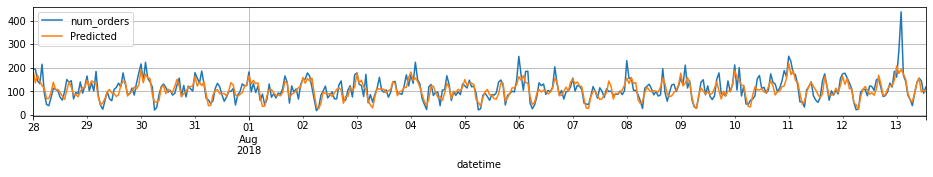

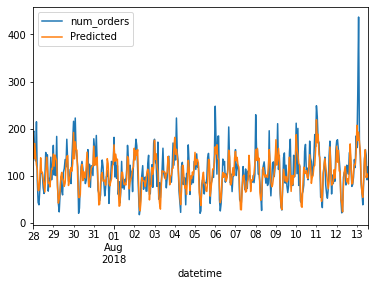

In [177]:
df = pd.DataFrame(target_valid)
df['Predicted'] = pd.Series(model.predict(features_valid),index=target_valid.index)
df.plot(figsize=(16, 2),grid=True)
df.plot()

In [178]:
features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=20)
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
prediction_valid = model.predict(features_valid)
prediction_test = model.predict(features_test)
print_rmse()

RMSE Train: 8, Valid: 30, Test: 43, diff(Train,Valid):298.6%


In [179]:
features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=7)
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
prediction_valid = model.predict(features_valid)
prediction_test = model.predict(features_test)
print_rmse()

RMSE Train: 15, Valid: 30, Test: 44, diff(Train,Valid):98.6%


In [180]:
features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=6)
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
prediction_valid = model.predict(features_valid)
prediction_test = model.predict(features_test)
print_rmse()

RMSE Train: 17, Valid: 31, Test: 45, diff(Train,Valid):81.3%


In [181]:
features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200, rolling_mean_size=10)
nleaves = 30
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'root_mean_squared_error'},
 'num_leaves': nleaves,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': 0
}
lgb_train = lgbm.Dataset(features_train, target_train)
lgb_valid = lgbm.Dataset(features_valid, target_valid, reference=lgb_train)
gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=800,
                valid_sets=lgb_valid,
                early_stopping_rounds=5,verbose_eval=100)

prediction_train = gbm.predict(features_train, num_iteration=gbm.best_iteration)
prediction_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
prediction_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print_rmse()

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[86]	valid_0's rmse: 29.669
RMSE Train: 13, Valid: 30, Test: 43, diff(Train,Valid):133.7%


In [182]:
features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200, rolling_mean_size=10)
nleaves = 17
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'root_mean_squared_error'},
 'num_leaves': nleaves,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': 0
}
lgb_train = lgbm.Dataset(features_train, target_train)
lgb_valid = lgbm.Dataset(features_valid, target_valid, reference=lgb_train)
gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=800,
                valid_sets=lgb_valid,
                early_stopping_rounds=5,verbose_eval=100)

prediction_train = gbm.predict(features_train, num_iteration=gbm.best_iteration)
prediction_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
prediction_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print_rmse()

Training until validation scores don't improve for 5 rounds.
[100]	valid_0's rmse: 29.1151
Early stopping, best iteration is:
[104]	valid_0's rmse: 29.0078
RMSE Train: 14, Valid: 29, Test: 44, diff(Train,Valid):100.4%
